In [4]:
import torch
import os
import h5py
import pandas as pd
import numpy as np
import shutil
from sklearn.model_selection import train_test_split
from utils.PathDataset import Pathology_Dataset_test
from torch.utils.data import Dataset, DataLoader
from utils.T1Dataset import T1Dataset_regression_mr_path_test
from models.SENet import Model_path_mr
from lifelines.utils import concordance_index
from models.MLP import MLP
import torch
import torchtuples as tt

from pycox.datasets import metabric
from pycox.models import CoxPH
from pycox.evaluation import EvalSurv
import matplotlib.pyplot as plt


In [9]:
base_dir = ['G:/glioma/final_data/huashan_MR/npy_file/TCGA_npy','G:/glioma/final_data/huashan_MR/npy_file/glioma_huashan_npy']
base_dir_path = ['G:/glioma/final_data/huashan_MR/pathology/TCGA','G:/glioma/final_data/huashan_MR/pathology/huashan']
df_dir = ['G:/glioma/final_data/glioma_survive/TCGA.csv','G:/glioma/final_data/glioma_survive/huashan.csv']
pth_dir = ['G:/glioma/final_data/glioma_survive/mr_pathology/survive_cnn_min_loss_path_and_mr.pth',
           'G:/glioma/final_data/glioma_survive/mr_pathology/survive_cnn_min_loss_path_and_mr_huashan.pth']
csv_dir = [['G:/glioma/final_data/glioma_survive/mr_pathology/test_TCGA.csv','G:/glioma/final_data/glioma_survive/mr_pathology/train_TCGA.csv',
           'G:/glioma/final_data/glioma_survive/mr_pathology/ex_test_huashan.csv','G:/glioma/final_data/glioma_survive/mr_pathology/ex_train_huashan.csv'],
           ['G:/glioma/final_data/glioma_survive/mr_pathology/test_huashan.csv','G:/glioma/final_data/MR_csv/glioma_survive/mr_pathology/train_huashan.csv',
            'G:/glioma/final_data/glioma_survivemr_pathology/ex_test_TCGA.csv','G:/glioma/final_data/glioma_survive/mr_pathology/ex_train_TCGA.csv']]
i = 0
ex_i = 1 # 外部验证
device = "cuda" if torch.cuda.is_available() else "cpu"
df = pd.read_csv(df_dir[i])
df_train, df_test, y_train, y_test = train_test_split(df,df['patient'],test_size=0.2,random_state=2022)
train_ds =T1Dataset_regression_mr_path_test(df_train,base_dir[i],base_dir_path[i])
test_ds = T1Dataset_regression_mr_path_test(df_test,base_dir[i],base_dir_path[i])
train_dl = DataLoader(
                        train_ds,
                        shuffle=True,
                        batch_size = 8,
    )
test_dl = DataLoader(
                        test_ds,
                        batch_size = 8,
    )
checkpoint = torch.load(pth_dir[i])
model = Model_path_mr()
model.load_state_dict(checkpoint['state_dict'])
model.to(device)
model.eval()
with torch.no_grad():
    for itr,(images,images_path,day,event,name) in enumerate(test_dl):
        name = np.array(name).tolist()
        images, images_path = images.to(device), images_path.to(device)
        risk_score = model(images.float(),images_path.float()).squeeze()
        if itr == 0:
            deep_score_test = risk_score.cpu()
            patient_test = name
        else:
            deep_score_test = torch.cat((deep_score_test, risk_score.cpu()),0)
            patient_test = patient_test + name
state_test = {
    'patient': patient_test,
    'score': deep_score_test
}
df_test_ = pd.DataFrame(state_test)
df_test_ = pd.merge(df_test_,df_test,how='inner')
df_test_.to_csv(csv_dir[i][0],index = False)

In [8]:
csv_dir[i][0]

'G:/glioma/final_data/glioma_survive/only_path/test_TCGA.csv'

In [6]:
with torch.no_grad():
    for itr,(images,images_path,day,event,name) in enumerate(train_dl):
        name = np.array(name).tolist()
        images, images_path = images.to(device), images_path.to(device)
        risk_score = model(images.float(),images_path.float()).squeeze()
        if itr == 0:
            deep_score_train = risk_score.cpu()
            patient_train = name
        else:
            deep_score_train = torch.cat((deep_score_train, risk_score.cpu()),0)
            patient_train = patient_train + name
state_train = {
    'patient': patient_train,
    'score': deep_score_train
}
df_train_ = pd.DataFrame(state_train)
df_train_ = pd.merge(df_train_,df_train,how='inner')
df_train_.to_csv(csv_dir[i][1],index = False)

In [10]:
df_ex = pd.read_csv(df_dir[ex_i])
df_train_ex, df_test_ex, y_train, y_test = train_test_split(df_ex,df_ex['patient'],test_size=0.69,random_state=10) 
train_ds_ex = T1Dataset_regression_mr_path_test(df_train_ex,base_dir[ex_i],base_dir_path[ex_i])
train_dl_ex = DataLoader(
                        train_ds_ex,
                        batch_size = 8,
    )
with torch.no_grad():
    for itr,(images,images_path,day,event,name) in enumerate(train_dl_ex):
        name = np.array(name).tolist()
        images, images_path = images.to(device), images_path.to(device)
        risk_score = model(images.float(),images_path.float()).squeeze()
        if itr == 0:
            deep_score_test_ex = risk_score.cpu()
            patient_test_ex = name
        else:
            deep_score_test_ex = torch.cat((deep_score_test_ex, risk_score.cpu()),0)
            patient_test_ex = patient_test_ex + name
state_test_ex = {
    'patient': patient_test_ex,
    'score': deep_score_test_ex
}
df_test_ex_ = pd.DataFrame(state_test_ex)
df_test_ex_ = pd.merge(df_test_ex_,df_train_ex,how='inner')
df_test_ex_.to_csv(csv_dir[i][3],index = False)


In [6]:
from sksurv.util import Surv
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
from sksurv.metrics import (
    concordance_index_censored,
    concordance_index_ipcw,
    cumulative_dynamic_auc,
    integrated_brier_score,
)
y_train_ = Surv.from_dataframe(
    event='status_dead', 
    time='survival_month', 
    data=df_train_)
y_test_ = Surv.from_dataframe(
    event='status_dead', 
    time='survival_month', 
    data=df_test_)
y_ex_test_ = Surv.from_dataframe(
    event='status_dead', 
    time='survival_month', 
    data=df_test_ex_)
hazard_label = ['score','WHO','Age','Gender','IDH']
train_feature = df_train_[hazard_label].values
test_feature = df_test_[hazard_label].values
ex_test_feature = df_test_ex_[hazard_label].values
# cox 模型
cph = CoxPHSurvivalAnalysis()
cph.fit(train_feature, y_train_)
cph_score = cph.score(test_feature,y_test_)
print("cph C-index: ", cph_score)
cph_score_ex = cph.score(ex_test_feature,y_ex_test_)
print("ex cph C-index: ", cph_score_ex)

cph C-index:  0.9508196721311475
ex cph C-index:  0.8002481389578163


Text(0.5, 1.0, 'Time ROC in Proposed Model')

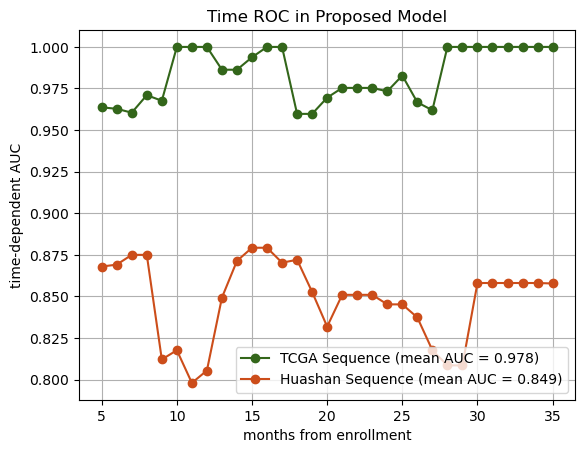

In [13]:
va_times = np.arange(5, 36, 1)
cph_risk_scores = cph.predict(test_feature)
cph_auc, cph_mean_auc = cumulative_dynamic_auc(y_train_, y_test_, cph_risk_scores, va_times)

cph_risk_scores_ex = cph.predict(ex_test_feature)
cph_auc_ex, cph_mean_auc_ex = cumulative_dynamic_auc(y_train_, y_ex_test_, cph_risk_scores_ex, va_times)




plt.plot(va_times, cph_auc,color=(0.2, 0.4, 0.1) ,marker="o",label=f"TCGA Sequence (mean AUC = {cph_mean_auc:.3f})")
plt.plot(va_times, cph_auc_ex,color=(0.8, 0.3, 0.1) ,marker="o",label=f"Huashan Sequence (mean AUC = {cph_mean_auc_ex:.3f})")
# plt.axhline(cph_mean_auc, linestyle="--",color=(0.8, 0.3, 0.1))

plt.xlabel("months from enrollment")
plt.ylabel("time-dependent AUC")
plt.legend(loc="lower right")
plt.grid(True)
plt.title('Time ROC in Proposed Model')

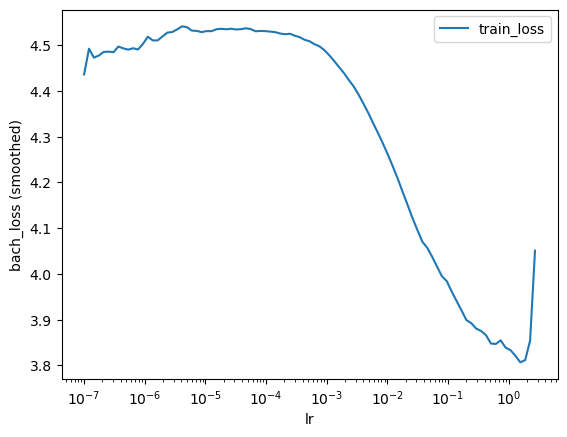

In [27]:
survival_label = ['survival_month','status_dead','score','WHO','Age','Gender','IDH']
df_train_[['score','WHO','Age','Gender','IDH']] = df_train_[['score','WHO','Age','Gender','IDH']].astype('float32')
get_target = lambda df_train_: (df_train_['survival_month'].values, df_train_['status_dead'].values)
y_train = get_target(df_train_)
train_feature = df_train_[['score','WHO','Age','Gender','IDH']].values

df_test_[['score','WHO','Age','Gender','IDH']] = df_test_[['score','WHO','Age','Gender','IDH']].astype('float32')
test_feature = df_test_[['score','WHO','Age','Gender','IDH']].values
get_target = lambda df_test_: (df_test_['survival_month'].values, df_test_['status_dead'].values)
y_test = get_target(df_test_)
test = tt.tuplefy(test_feature, y_test)
durations_test, events_test = get_target(df_test_)



in_features = train_feature.shape[1]
num_nodes = [32, 32]
out_features = 1
batch_norm = True
dropout = 0.1
output_bias = False

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm,
                              dropout, output_bias=output_bias)
model_cph = CoxPH(net, tt.optim.Adam)
batch_size = 256
lrfinder = model_cph.lr_finder(train_feature, y_train, batch_size, tolerance=10)
_ = lrfinder.plot()

In [28]:
model_cph.optimizer.set_lr(0.01)
epochs = 1000
callbacks = [tt.callbacks.EarlyStopping()]
verbose = True
log = model_cph.fit(train_feature, y_train, batch_size, epochs, callbacks, verbose,
                val_data=test, val_batch_size=batch_size)

0:	[0s / 0s],		train_loss: 4.5524,	val_loss: 2.6193
1:	[0s / 0s],		train_loss: 3.9764,	val_loss: 2.5657
2:	[0s / 0s],		train_loss: 3.6927,	val_loss: 2.5684
3:	[0s / 0s],		train_loss: 3.5732,	val_loss: 2.5280
4:	[0s / 0s],		train_loss: 3.4389,	val_loss: 2.4309
5:	[0s / 0s],		train_loss: 3.4117,	val_loss: 2.3067
6:	[0s / 0s],		train_loss: 3.3629,	val_loss: 2.1517
7:	[0s / 0s],		train_loss: 3.2244,	val_loss: 1.9701
8:	[0s / 0s],		train_loss: 3.0986,	val_loss: 1.8013
9:	[0s / 0s],		train_loss: 3.1344,	val_loss: 1.7317
10:	[0s / 0s],		train_loss: 3.0681,	val_loss: 1.7058
11:	[0s / 0s],		train_loss: 3.1122,	val_loss: 1.6956
12:	[0s / 0s],		train_loss: 3.0694,	val_loss: 1.6857
13:	[0s / 0s],		train_loss: 2.9612,	val_loss: 1.6975
14:	[0s / 0s],		train_loss: 3.0115,	val_loss: 1.7479
15:	[0s / 0s],		train_loss: 3.0427,	val_loss: 1.7815
16:	[0s / 0s],		train_loss: 2.9946,	val_loss: 1.7851
17:	[0s / 0s],		train_loss: 2.9948,	val_loss: 1.7728
18:	[0s / 0s],		train_loss: 2.9847,	val_loss: 1.7484
19:

In [31]:
_ = model_cph.compute_baseline_hazards()
surv = model_cph.predict_surv_df(test_feature)
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')
ev.concordance_td()

0.9262295081967213

In [33]:
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
ev.integrated_brier_score(time_grid)

0.07461889820307216

In [90]:
from lifelines import CoxPHFitter
col = ['survival_month','status_dead','score','WHO','Age','Gender','IDH']
cph = CoxPHFitter()
cph.fit(df_train_[col], duration_col='survival_month', event_col='status_dead')
cph_score = cph.score(df_test_ex_[col], scoring_method='concordance_index')
print("ex_CPH C-index: ", cph_score)
cph_score = cph.score(df_test_[col], scoring_method='concordance_index')
print("CPH C-index: ", cph_score)

-1.4050531450880075